In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import netron
from fastai.vision.gan import *
import pandas as pd
import os
from tqdm import tqdm
import image_scraper

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

# Gan Part

In [134]:
verify_images(path)

cannot identify image file <_io.BufferedReader name='data/62823_2019.jpg'>
cannot identify image file <_io.BufferedReader name='data/6339_2003.jpg'>
cannot identify image file <_io.BufferedReader name='data/6955_2003.jpg'>
cannot identify image file <_io.BufferedReader name='data/54405_2016.jpg'>
cannot identify image file <_io.BufferedReader name='data/43570_2013.jpg'>
cannot identify image file <_io.BufferedReader name='data/55382_2016.jpg'>
cannot identify image file <_io.BufferedReader name='data/3781_2002.jpg'>
cannot identify image file <_io.BufferedReader name='data/55695_2016.jpg'>
cannot identify image file <_io.BufferedReader name='data/20561_2008.jpg'>
cannot identify image file <_io.BufferedReader name='data/55501_2016.jpg'>
cannot identify image file <_io.BufferedReader name='data/23057_2008.jpg'>
cannot identify image file <_io.BufferedReader name='data/62546_2019.jpg'>
cannot identify image file <_io.BufferedReader name='data/7058_2003.jpg'>
cannot identify image file <_

In [2]:
path = Path("data/")

In [3]:
def get_data(bs, size):
    return (
        GANItemList.from_folder(path, noise_sz=100)
        .split_none()
        .label_from_func(noop)
        .transform(
            tfms=[[crop_pad(size=size, row_pct=(0, 1), col_pct=(0, 1))], []],
            size=size,
            tfm_y=True,
        )
        .databunch(bs=bs)
        .normalize(
            stats=[torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])],
            do_x=False,
            do_y=True,
        )
    )

In [4]:
data = get_data(128, 64)

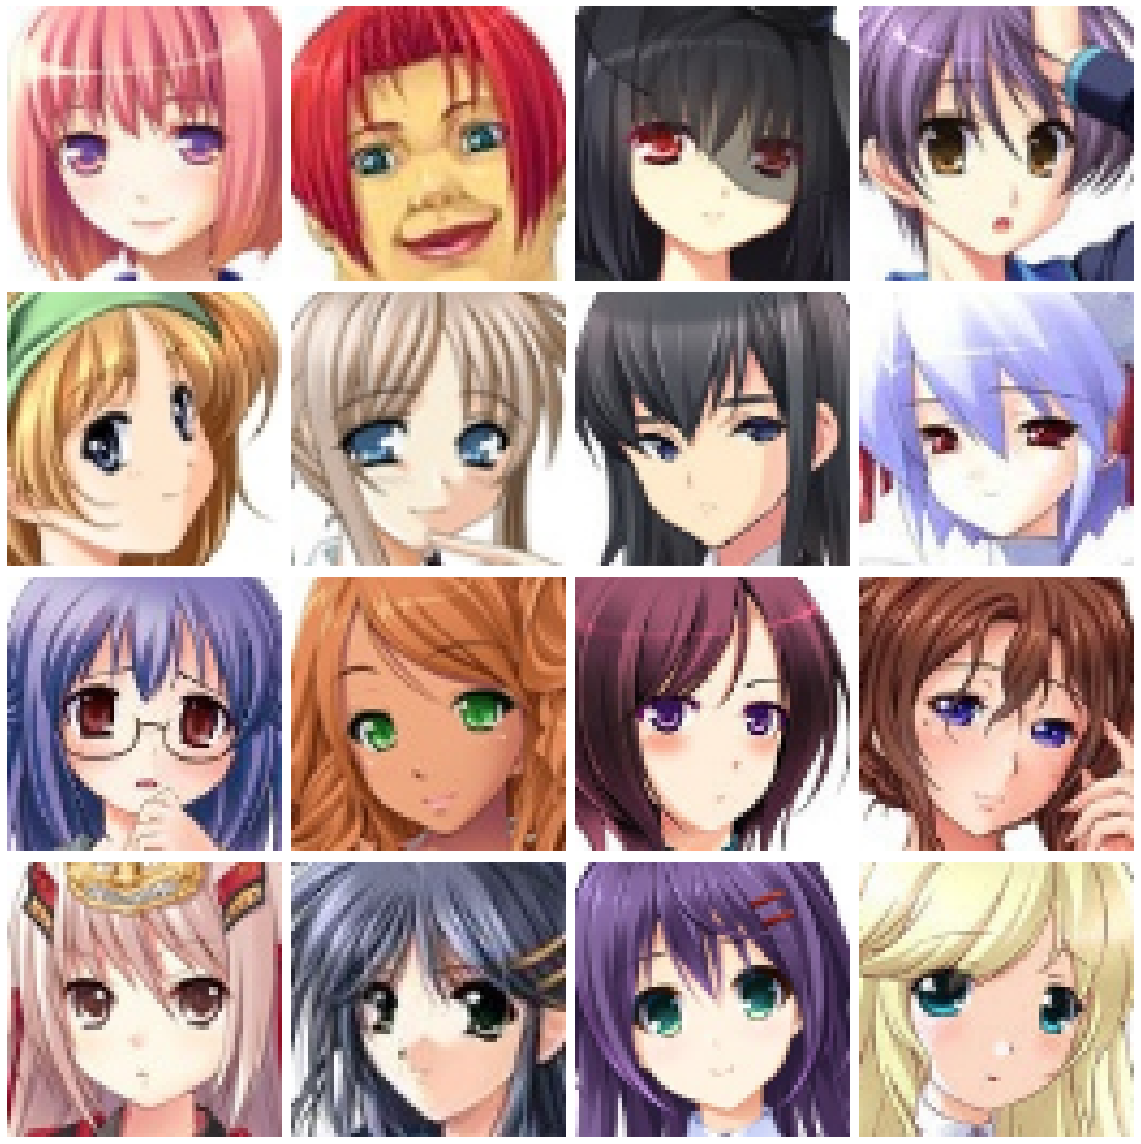

In [5]:
data.show_batch(4)

In [137]:
data.c

3

In [6]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic = basic_critic(in_size=64, n_channels=3, n_extra_layers=1)

In [7]:
learn = GANLearner.wgan(
    data,
    generator,
    critic,
    switch_eval=False,
    opt_func=partial(AdamW, betas=(0.0, 0.99)),
    wd=0.0,
)

In [14]:
dummy_input = Variable(torch.randn(1, 100, 64, 64)).cuda()
torch.onnx.export(critic, dummy_input, "model.onnx")
netron.start("model.onnx")

RuntimeError: Given groups=1, weight of size 64 3 4 4, expected input[1, 100, 64, 64] to have 3 channels, but got 100 channels instead

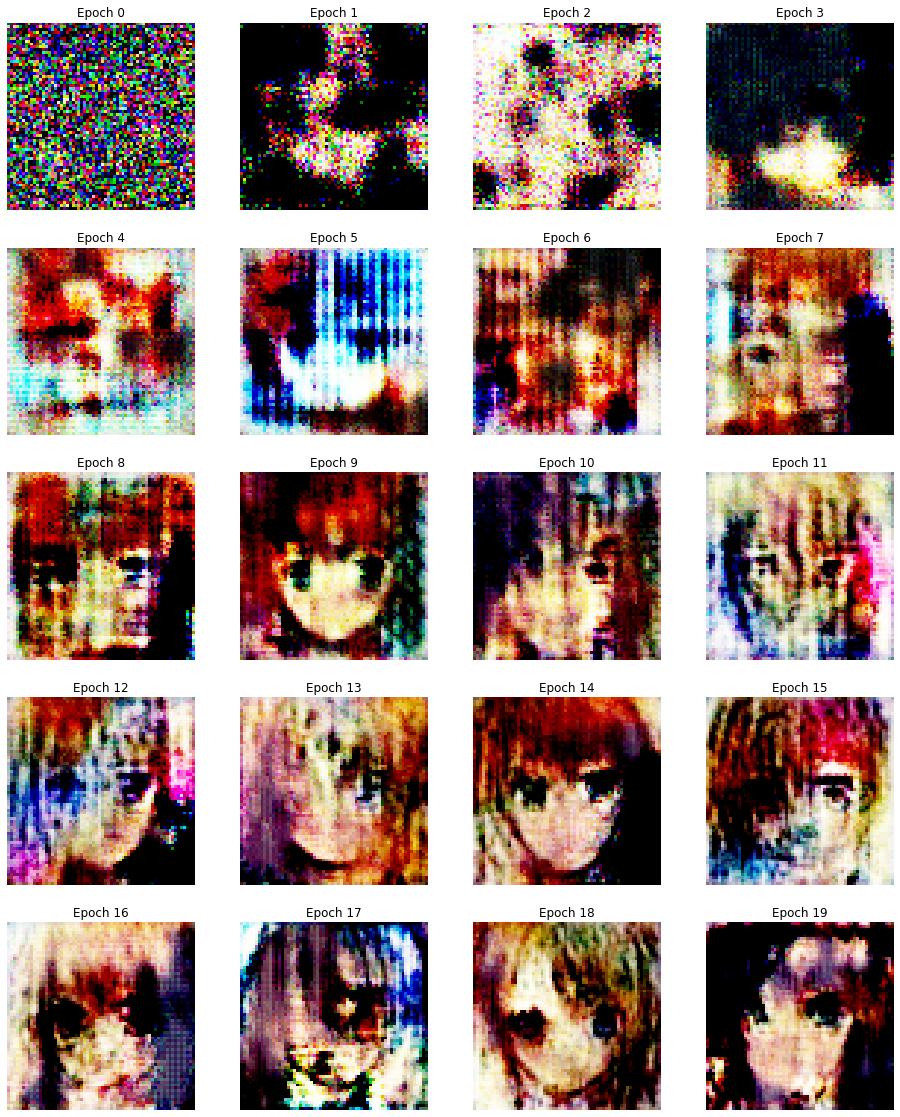

In [142]:
learn.fit(20, 2e-4)

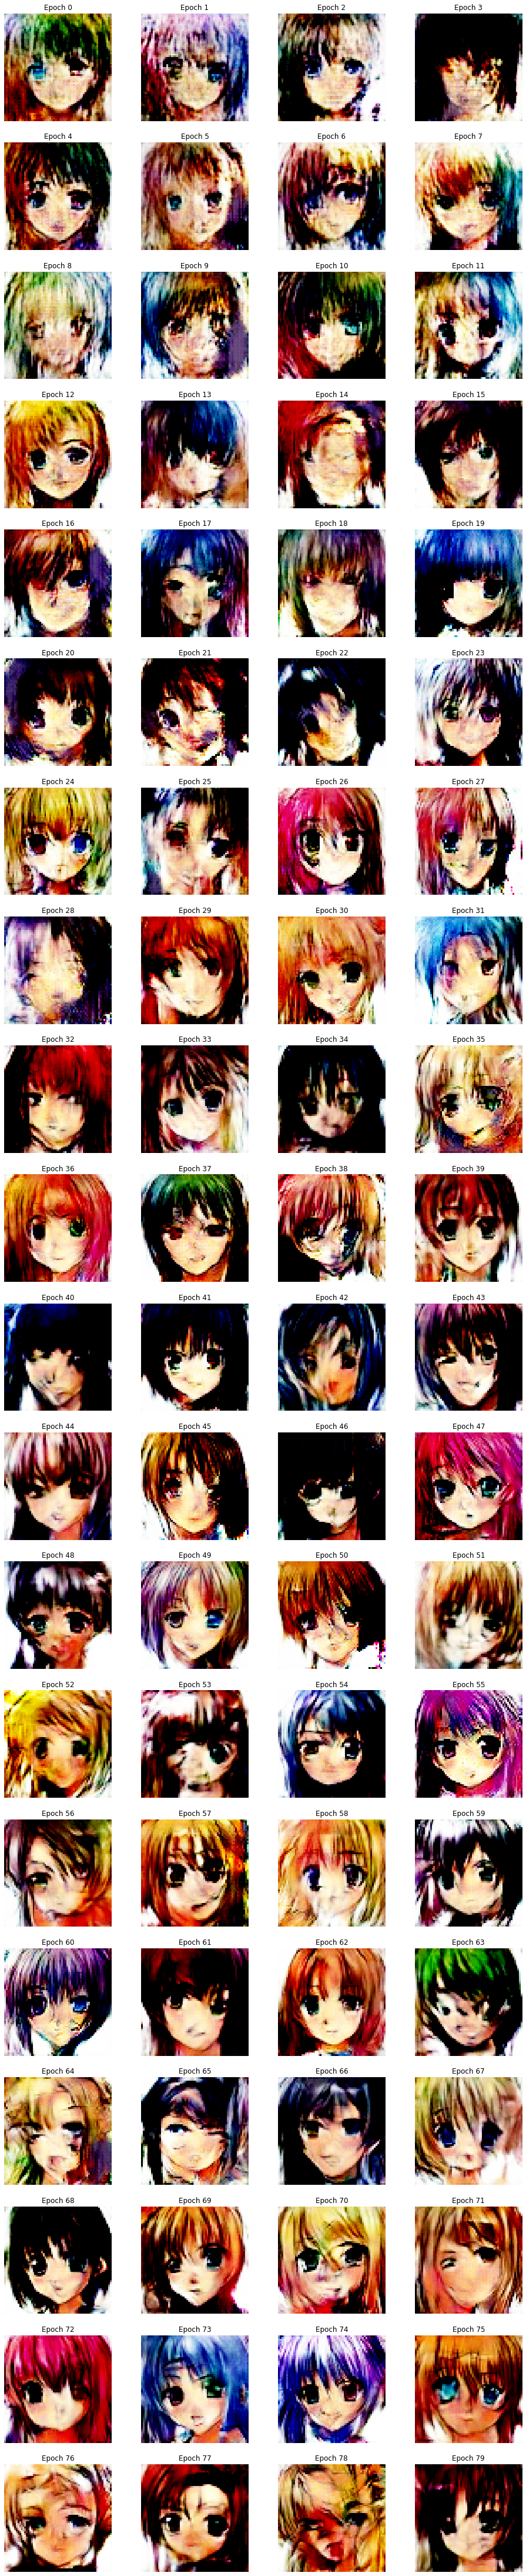

In [143]:
learn.unfreeze()
learn.fit(80, 2e-4)

In [144]:
learn.save("stage-1")

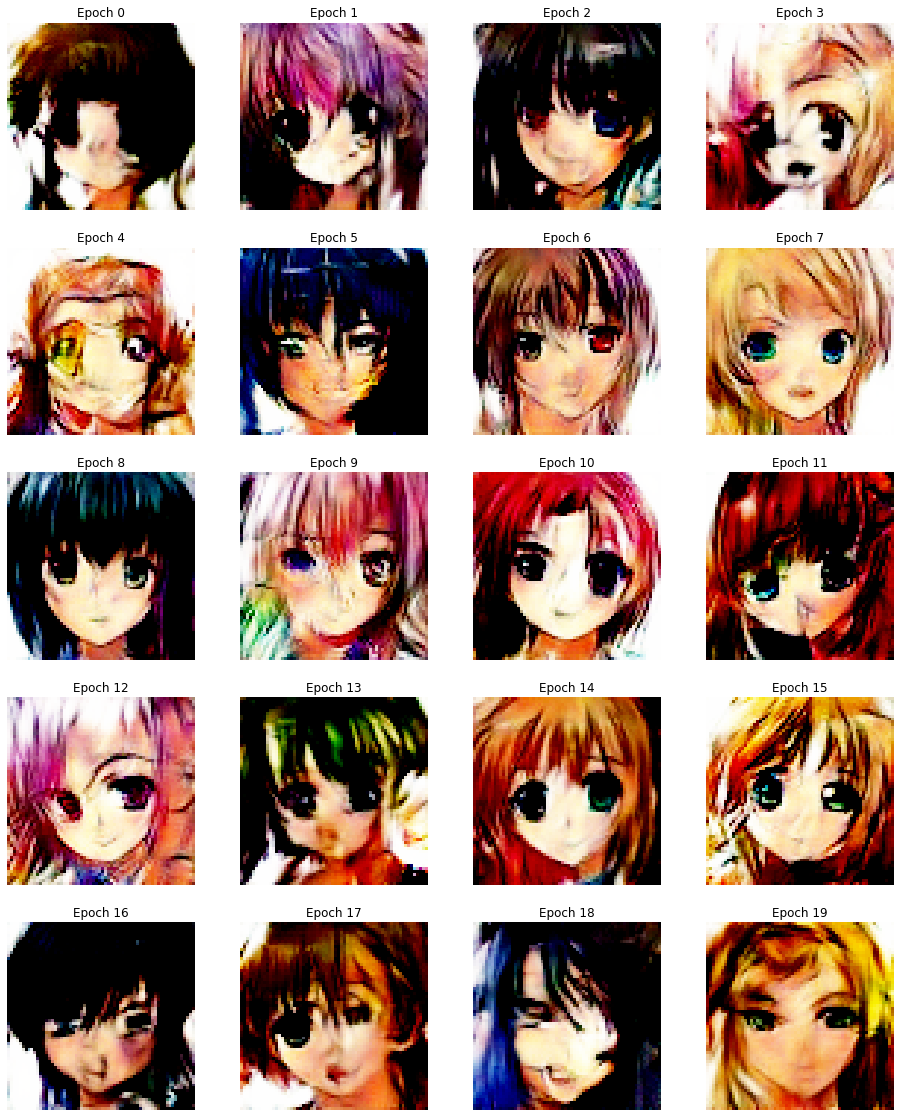

In [145]:
learn.unfreeze()
learn.fit(20, 2e-4)

In [146]:
learn.save("stage-2")

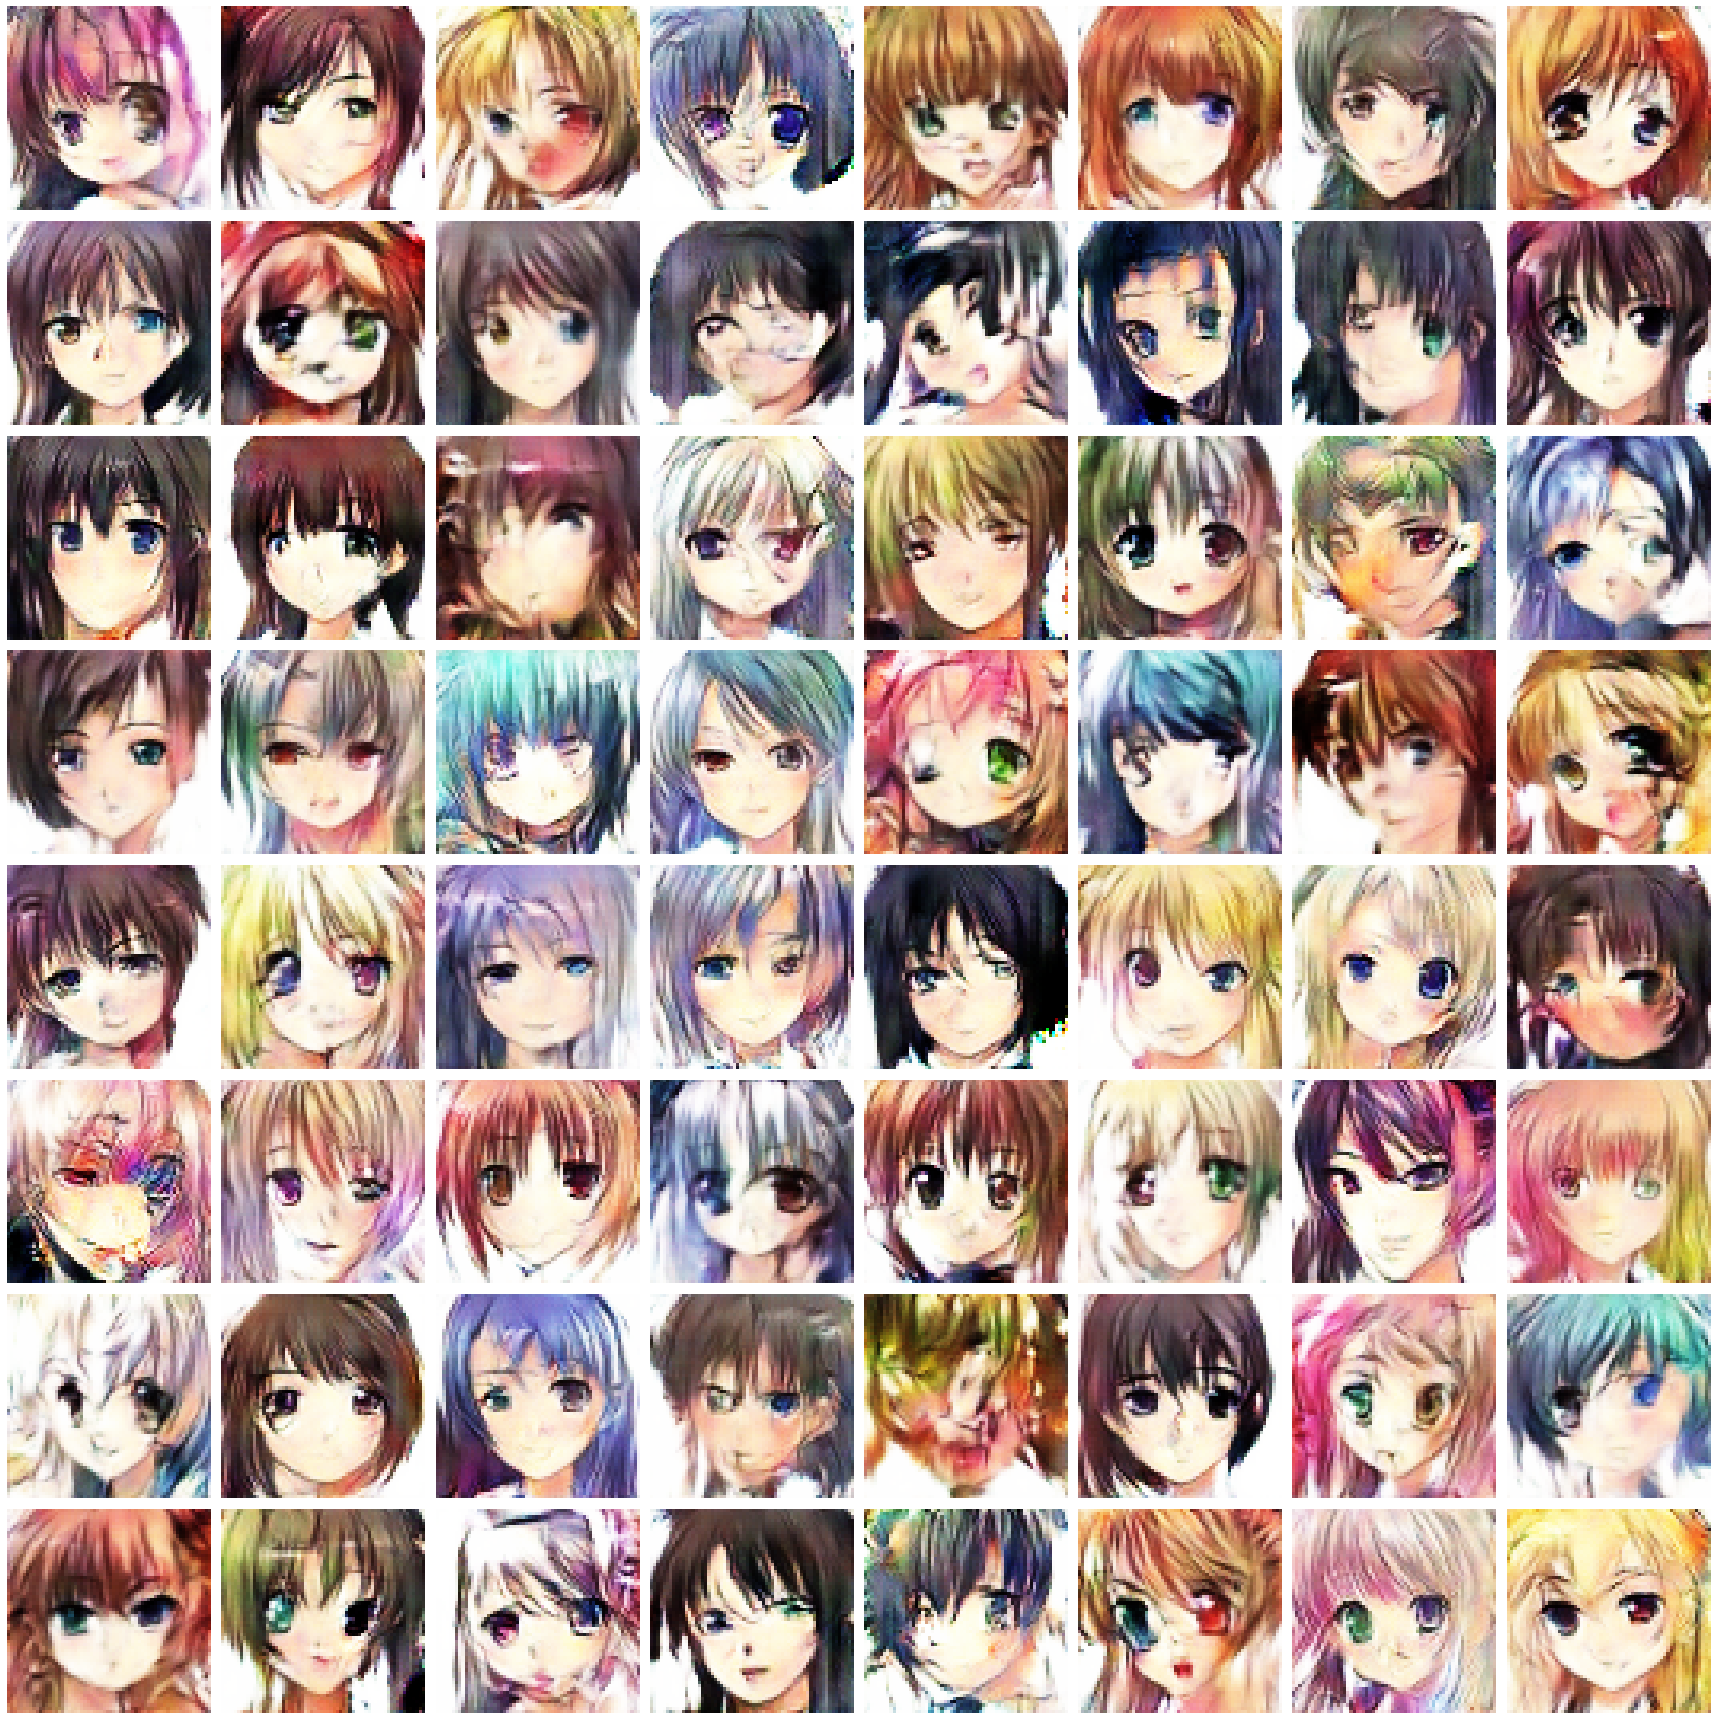

In [148]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(24, 24))

In [157]:
learn = None
gc.collect()

48193

In [172]:
data = get_data(128, 64)

In [174]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(AdamW, betas = (0.,0.99)), wd=0.1)

In [175]:
learn.load("stage-2")

GANLearner(data=ImageDataBunch;

Train: LabelList (63569 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: data;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: data;

Test: None, model=GANModule(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, mo

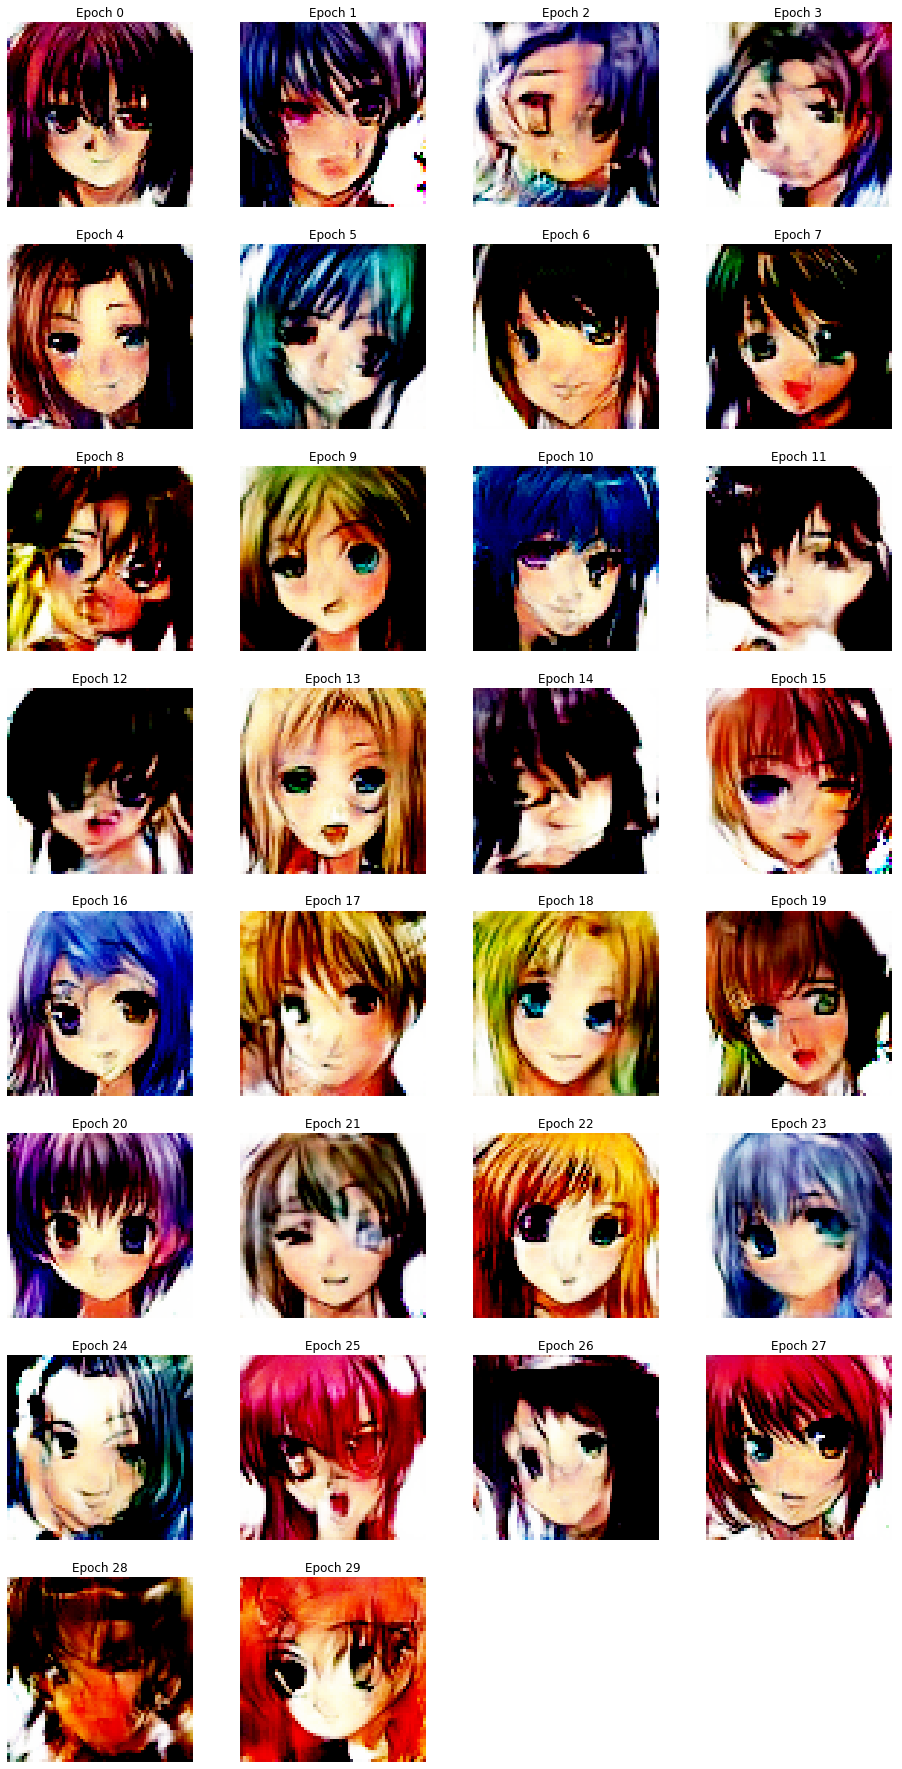

In [176]:
learn.unfreeze()
learn.fit(30, 2e-4)

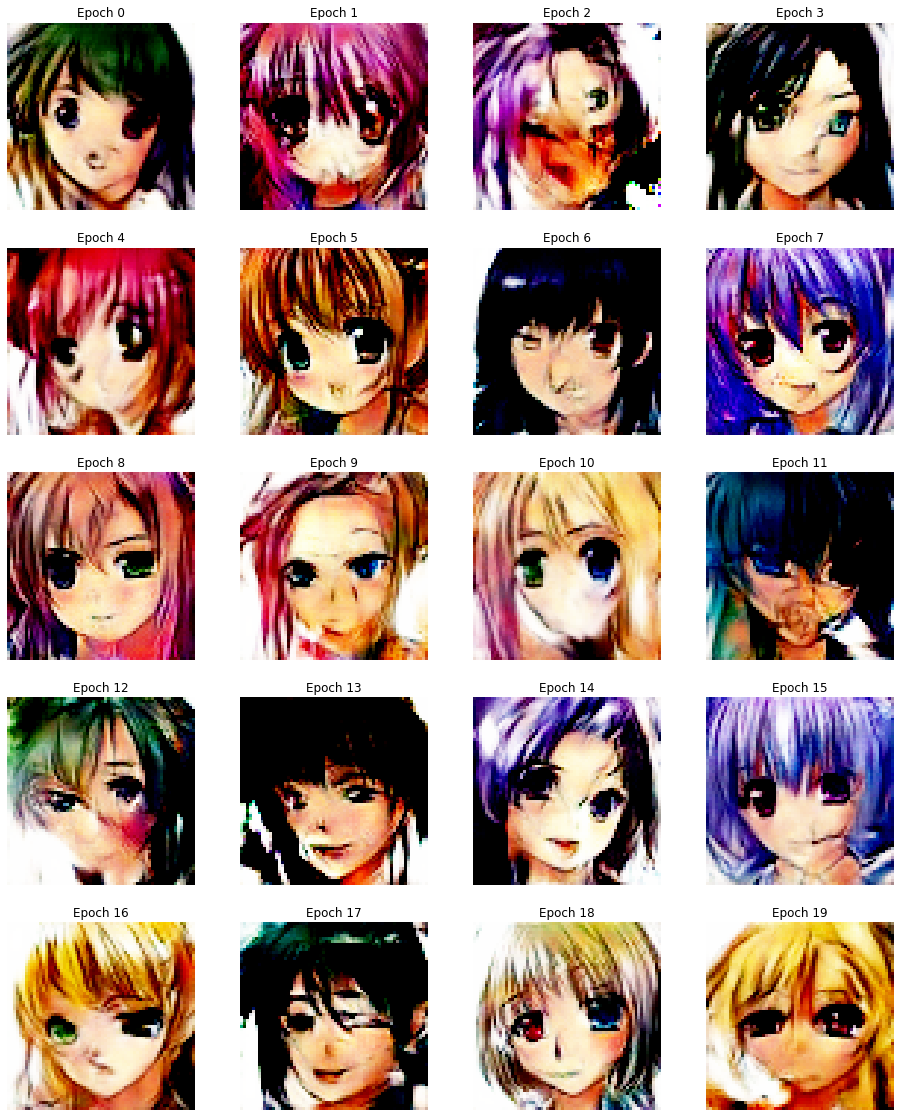

In [179]:
learn.unfreeze()
learn.fit(20, 2e-4)

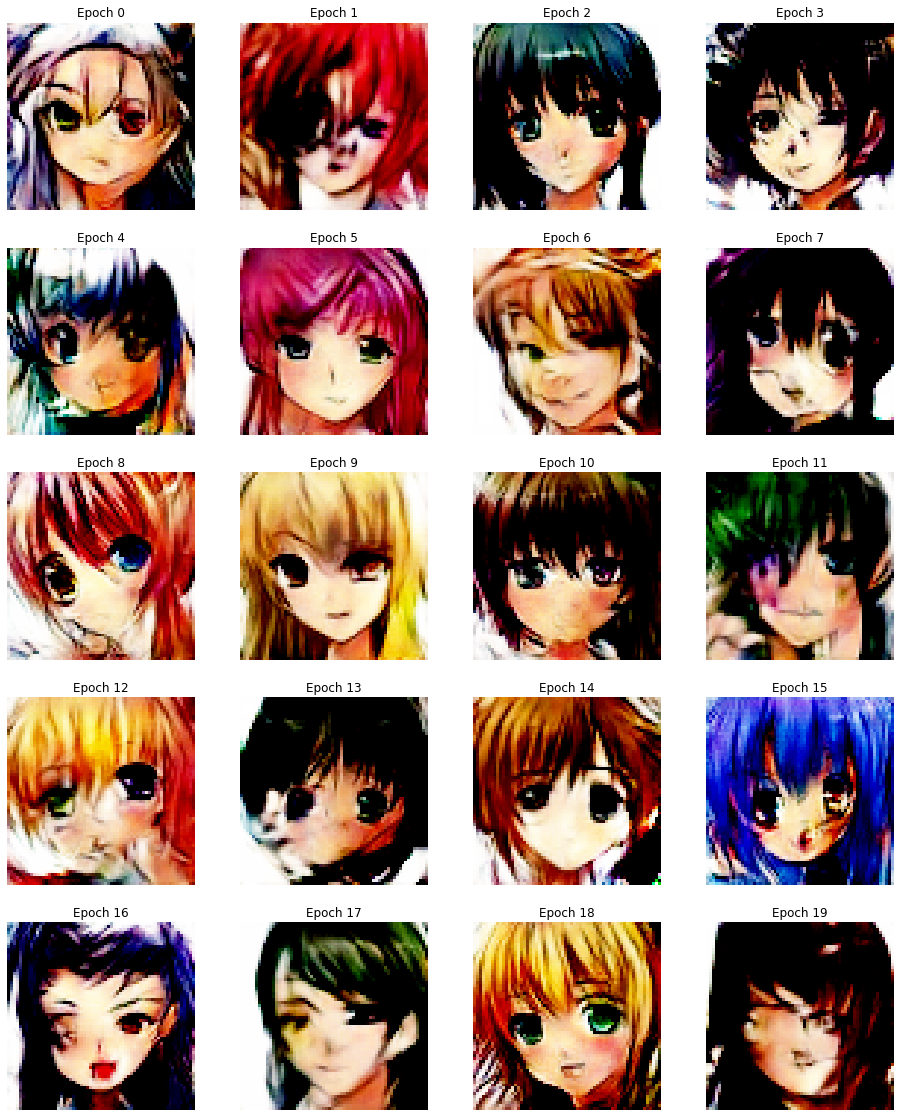

In [180]:
learn.unfreeze()
learn.fit(20, 2e-4)

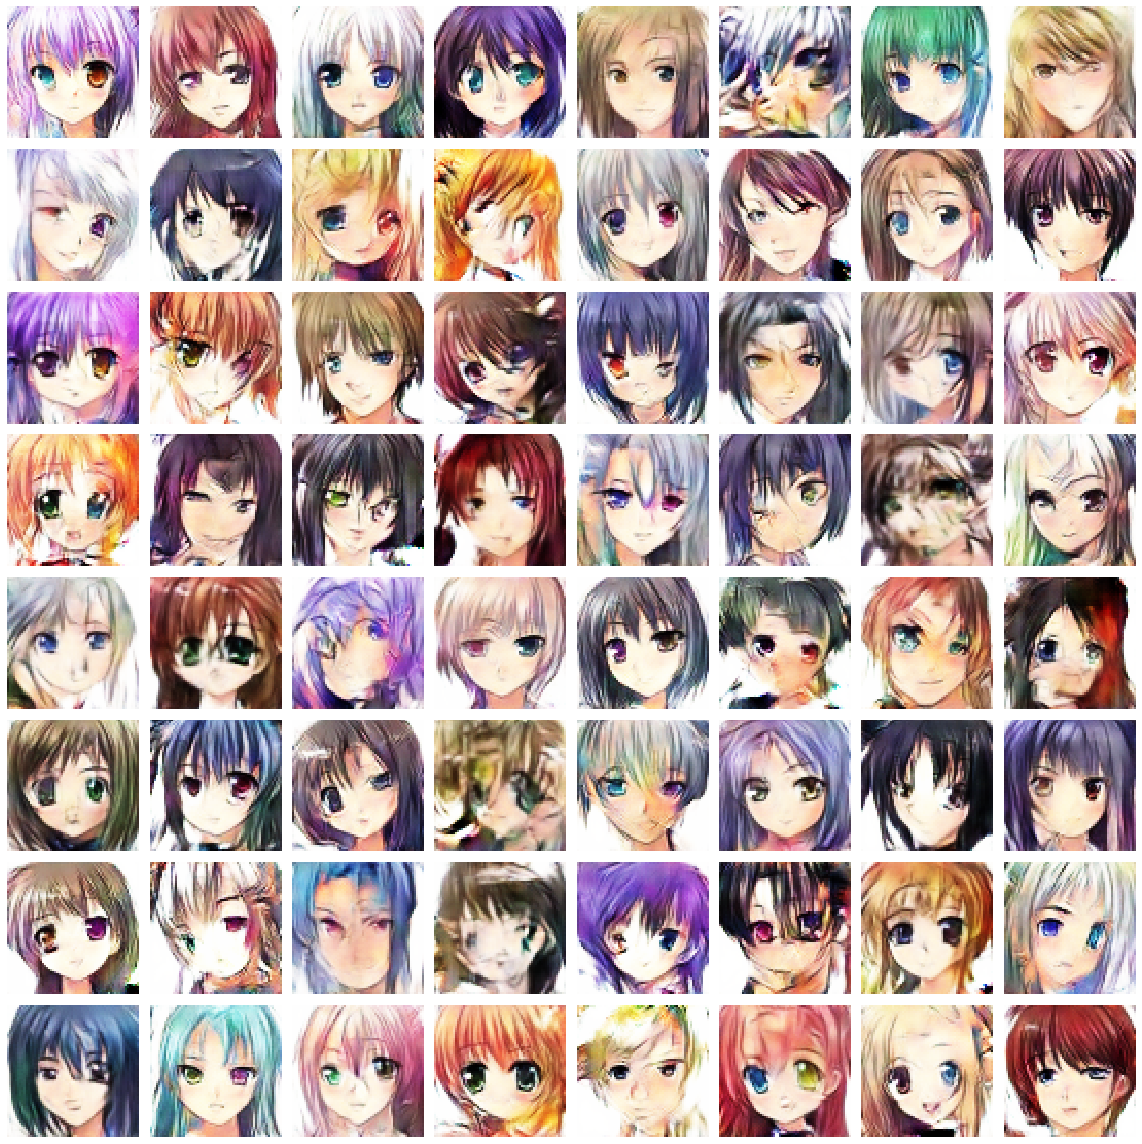

In [181]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(16, 16))

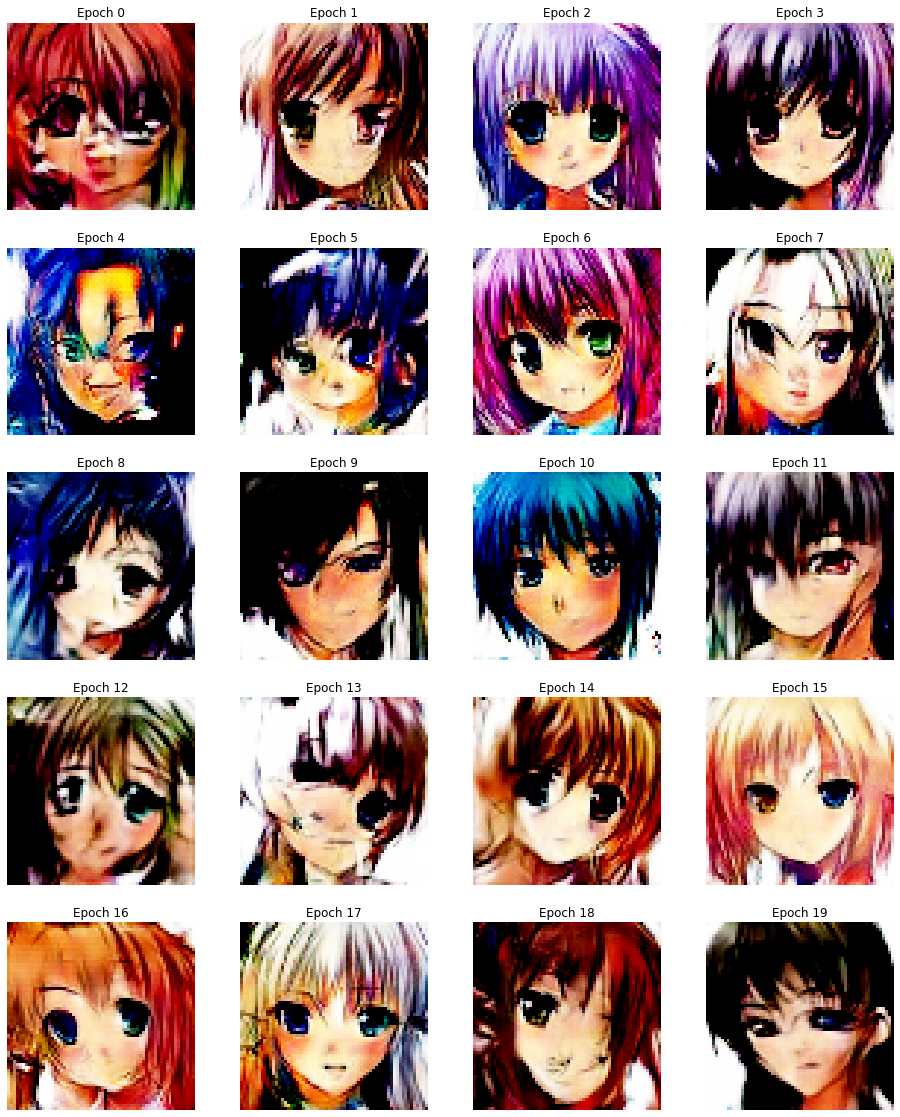

In [182]:
learn.gan_trainer.switch(gen_mode=False)
learn.unfreeze()
learn.fit(20, 2e-4)

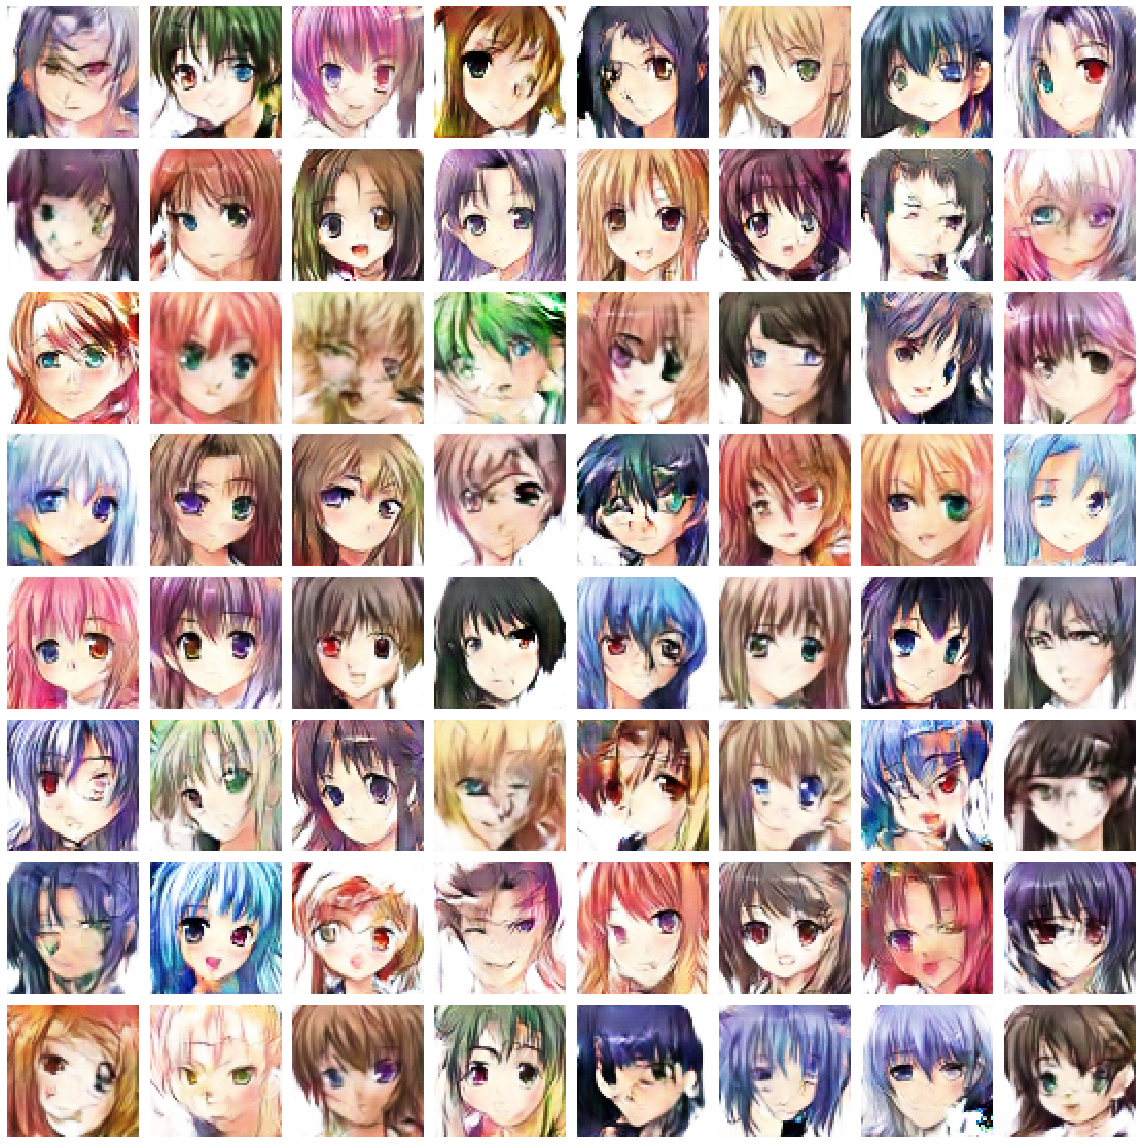

In [183]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(16, 16))

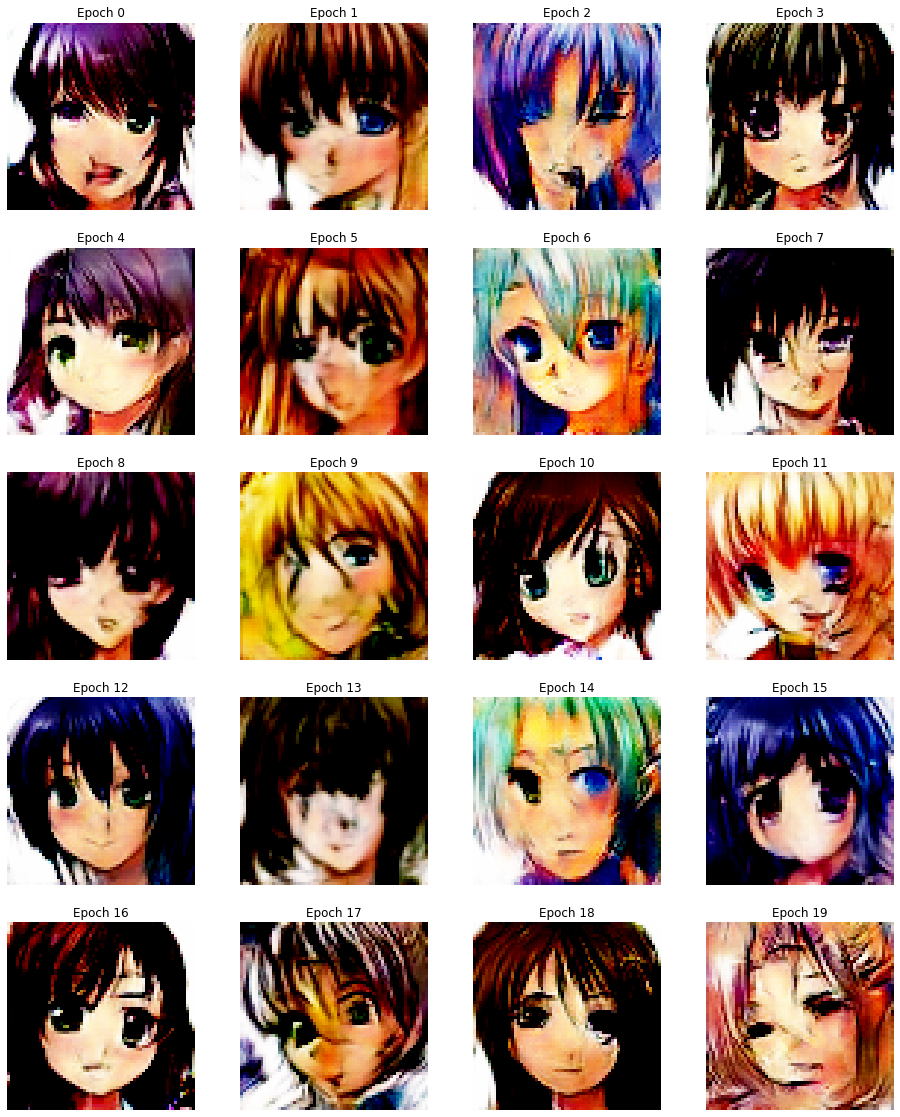

In [184]:
learn.unfreeze()
learn.fit(20, 2e-4)

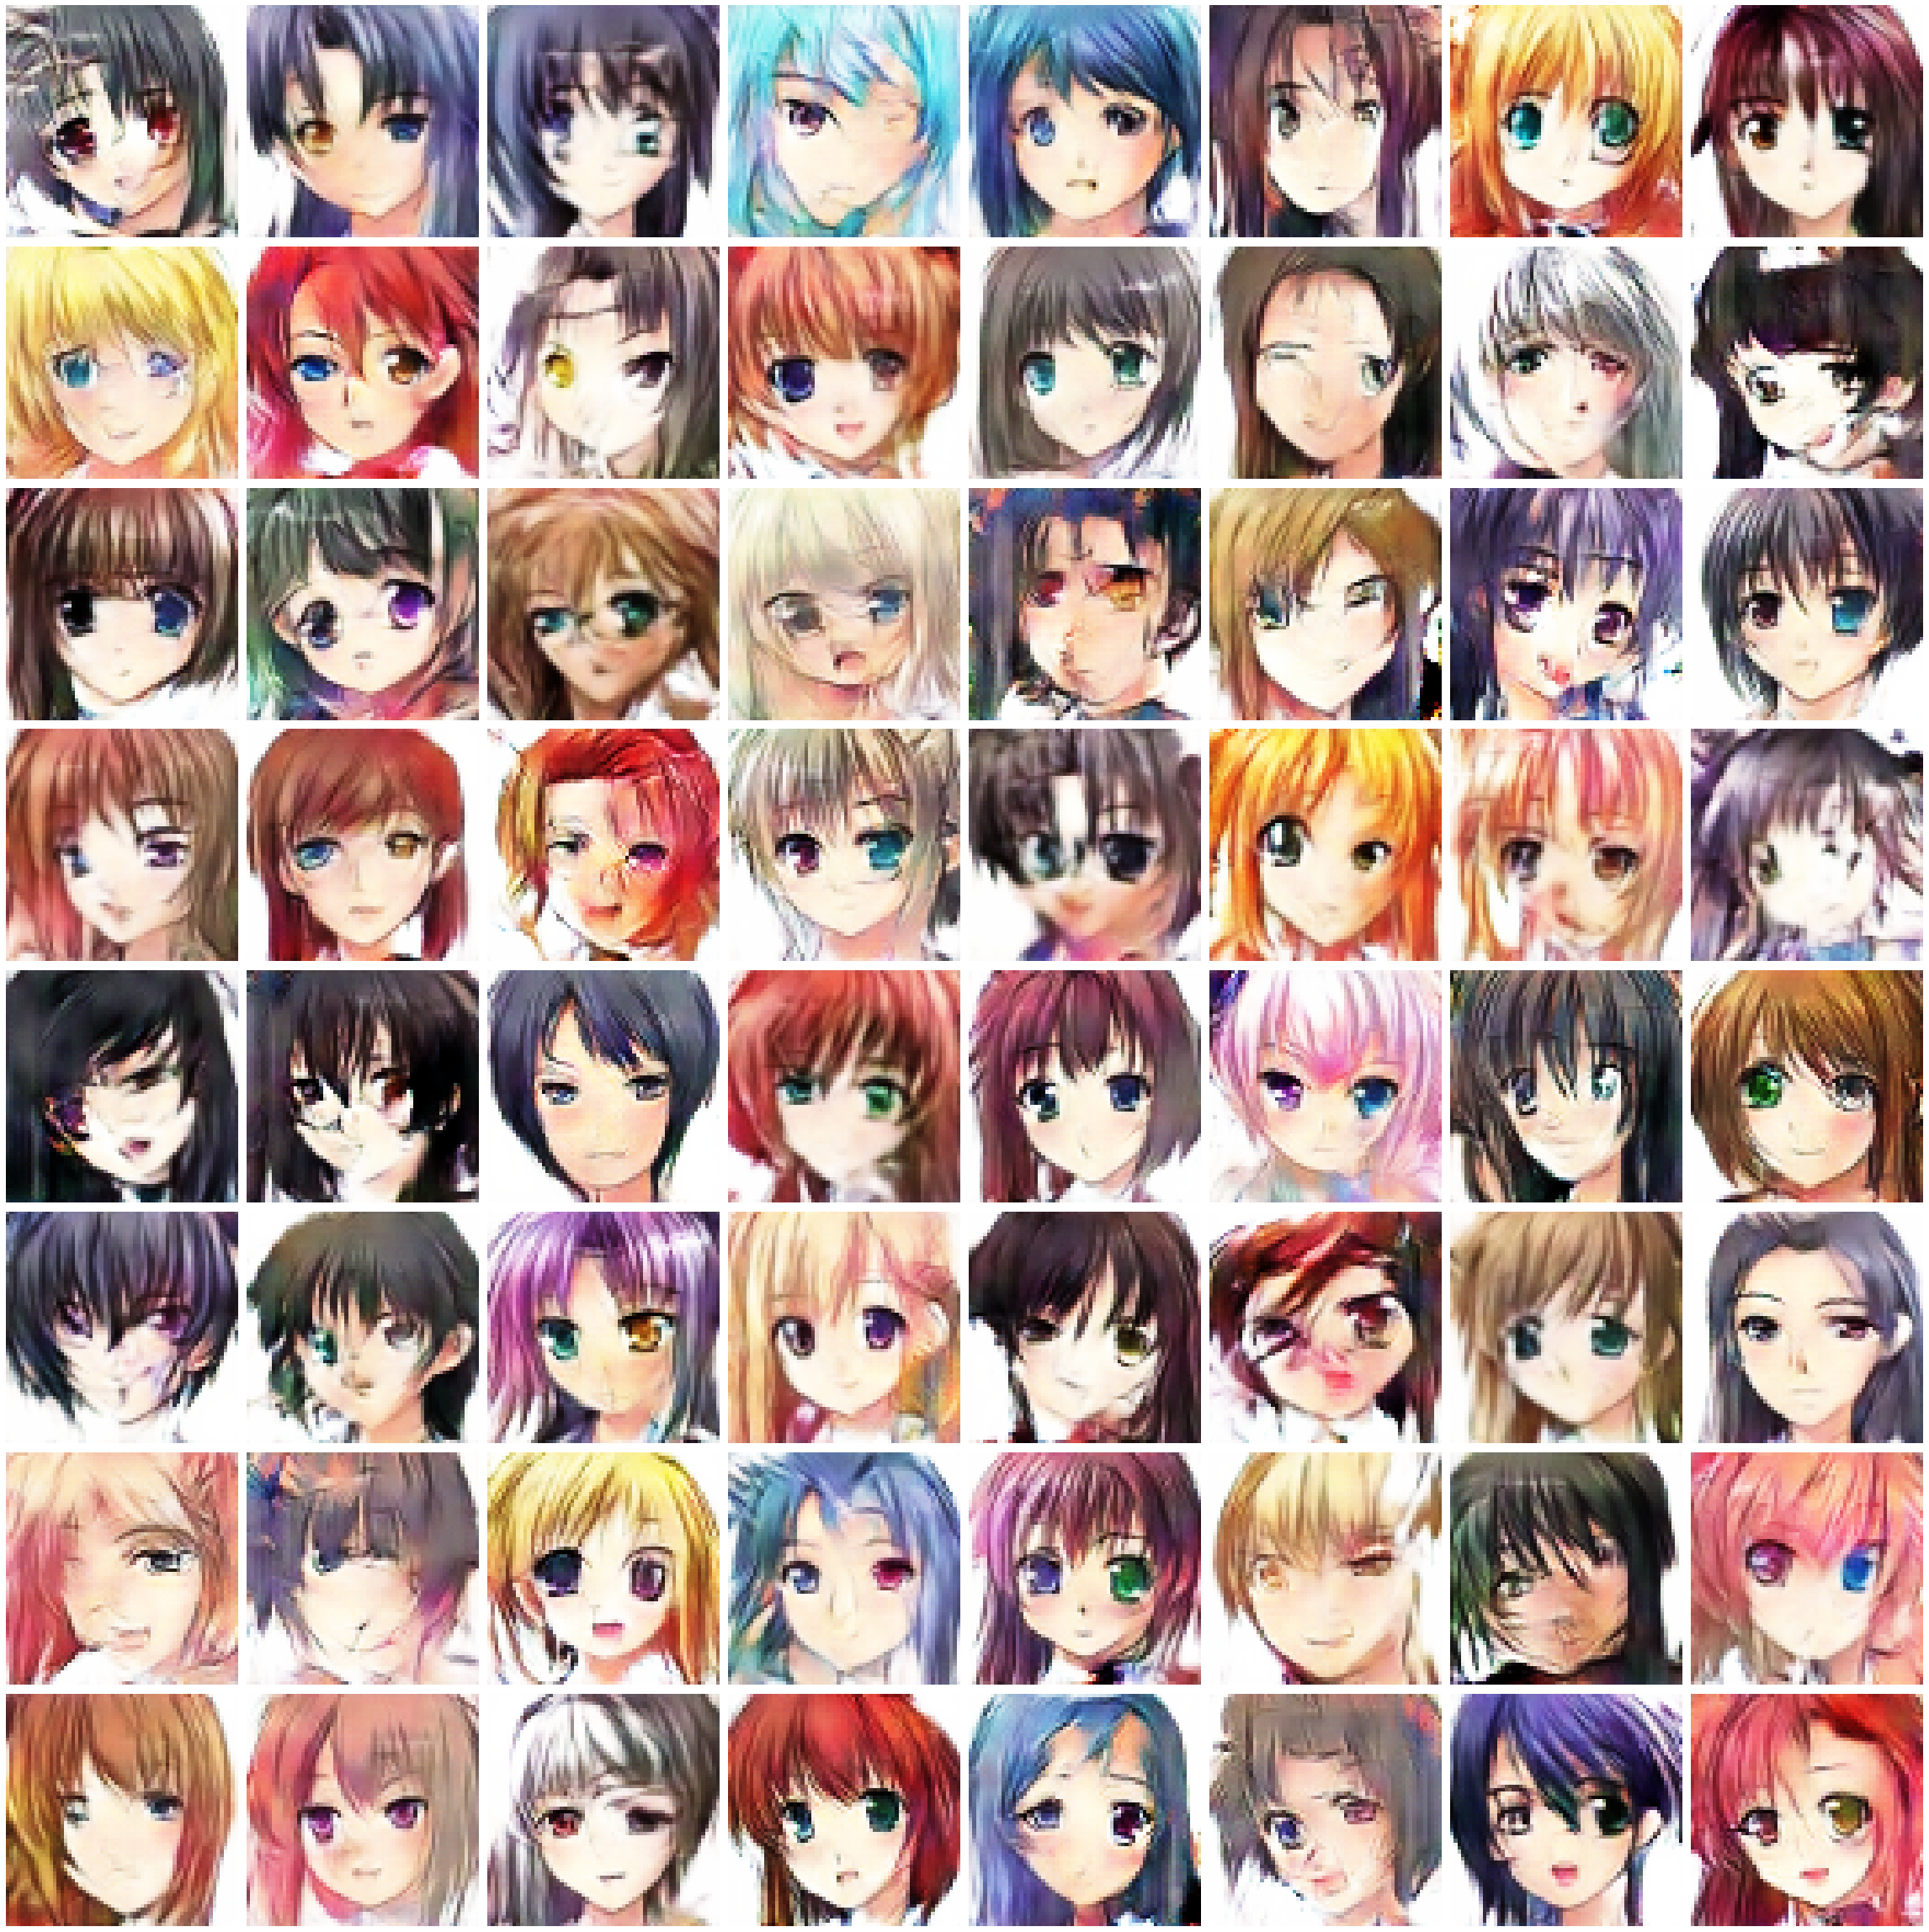

In [199]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=8, figsize=(32, 32))

In [200]:
learn.save('fin')